In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    if gQs_notequal.shape[0] > 0:
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                        labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
#     if gQs_equal.shape[0] > 0:
#         rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
#         dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
#                                                                         labels=rates_equal)) # 0-1
#         targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
#         dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
#                                                                         labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:22.0000 R:22.0000 rate:0.0440 gloss:1.3811 dloss:1.3672 glossQ:1.0044 dlossQ:1.9149 exploreP:0.9978
Episode:1 meanR:19.5000 R:17.0000 rate:0.0340 gloss:1.3840 dloss:1.3696 glossQ:1.0047 dlossQ:1.8926 exploreP:0.9961
Episode:2 meanR:20.3333 R:22.0000 rate:0.0440 gloss:1.3819 dloss:1.3696 glossQ:1.0124 dlossQ:1.8746 exploreP:0.9940
Episode:3 meanR:30.2500 R:60.0000 rate:0.1200 gloss:1.3845 dloss:1.3667 glossQ:1.0034 dlossQ:1.8081 exploreP:0.9881
Episode:4 meanR:27.4000 R:16.0000 rate:0.0320 gloss:1.3846 dloss:1.3700 glossQ:1.0029 dlossQ:1.7711 exploreP:0.9865
Episode:5 meanR:24.6667 R:11.0000 rate:0.0220 gloss:1.3822 dloss:1.3664 glossQ:1.0027 dlossQ:1.7447 exploreP:0.9855
Episode:6 meanR:22.8571 R:12.0000 rate:0.0240 gloss:1.3826 dloss:1.3674 glossQ:1.0024 dlossQ:1.7127 exploreP:0.9843
Episode:7 meanR:23.0000 R:24.0000 rate:0.0480 gloss:1.3844 dloss:1.3664 glossQ:1.0026 dlossQ:1.7114 exploreP:0.9820
Episode:8 meanR:22.0000 R:14.0000 rate:0.0280 gloss:1.3859 dloss:1.3714 

Episode:71 meanR:22.8333 R:12.0000 rate:0.0240 gloss:1.3327 dloss:1.3313 glossQ:1.0476 dlossQ:1.1002 exploreP:0.8499
Episode:72 meanR:22.6986 R:13.0000 rate:0.0260 gloss:1.3375 dloss:1.3360 glossQ:1.0330 dlossQ:1.1275 exploreP:0.8488
Episode:73 meanR:23.0811 R:51.0000 rate:0.1020 gloss:1.3249 dloss:1.3241 glossQ:1.0380 dlossQ:1.0511 exploreP:0.8446
Episode:74 meanR:23.1067 R:25.0000 rate:0.0500 gloss:1.3223 dloss:1.3217 glossQ:1.0372 dlossQ:1.0287 exploreP:0.8425
Episode:75 meanR:22.9342 R:10.0000 rate:0.0200 gloss:1.3303 dloss:1.3295 glossQ:1.0310 dlossQ:1.0845 exploreP:0.8416
Episode:76 meanR:22.8182 R:14.0000 rate:0.0280 gloss:1.3233 dloss:1.3227 glossQ:1.0321 dlossQ:1.0640 exploreP:0.8405
Episode:77 meanR:22.9359 R:32.0000 rate:0.0640 gloss:1.3230 dloss:1.3224 glossQ:1.0338 dlossQ:1.0180 exploreP:0.8378
Episode:78 meanR:22.8734 R:18.0000 rate:0.0360 gloss:1.3230 dloss:1.3222 glossQ:1.0375 dlossQ:1.0708 exploreP:0.8363
Episode:79 meanR:22.7250 R:11.0000 rate:0.0220 gloss:1.3244 dlos

Episode:141 meanR:20.1400 R:11.0000 rate:0.0220 gloss:1.3206 dloss:1.3203 glossQ:1.0306 dlossQ:1.0429 exploreP:0.7446
Episode:142 meanR:20.1800 R:18.0000 rate:0.0360 gloss:1.3212 dloss:1.3209 glossQ:1.0310 dlossQ:1.0263 exploreP:0.7433
Episode:143 meanR:20.4200 R:43.0000 rate:0.0860 gloss:1.3204 dloss:1.3203 glossQ:1.0332 dlossQ:1.0378 exploreP:0.7401
Episode:144 meanR:20.4200 R:15.0000 rate:0.0300 gloss:1.3319 dloss:1.3317 glossQ:1.0396 dlossQ:1.0373 exploreP:0.7390
Episode:145 meanR:20.4800 R:23.0000 rate:0.0460 gloss:1.3242 dloss:1.3241 glossQ:1.0328 dlossQ:1.0423 exploreP:0.7373
Episode:146 meanR:20.7400 R:39.0000 rate:0.0780 gloss:1.3234 dloss:1.3232 glossQ:1.0303 dlossQ:1.0421 exploreP:0.7345
Episode:147 meanR:20.7300 R:16.0000 rate:0.0320 gloss:1.3249 dloss:1.3247 glossQ:1.0332 dlossQ:1.0340 exploreP:0.7334
Episode:148 meanR:20.7200 R:12.0000 rate:0.0240 gloss:1.3262 dloss:1.3258 glossQ:1.0318 dlossQ:1.0380 exploreP:0.7325
Episode:149 meanR:20.3100 R:12.0000 rate:0.0240 gloss:1.

Episode:211 meanR:19.0700 R:13.0000 rate:0.0260 gloss:1.3263 dloss:1.3262 glossQ:1.0296 dlossQ:1.0288 exploreP:0.6533
Episode:212 meanR:19.0800 R:13.0000 rate:0.0260 gloss:1.3299 dloss:1.3300 glossQ:1.0294 dlossQ:1.0295 exploreP:0.6525
Episode:213 meanR:18.7500 R:13.0000 rate:0.0260 gloss:1.3274 dloss:1.3274 glossQ:1.0315 dlossQ:1.0361 exploreP:0.6516
Episode:214 meanR:18.8300 R:22.0000 rate:0.0440 gloss:1.3221 dloss:1.3220 glossQ:1.0319 dlossQ:1.0284 exploreP:0.6502
Episode:215 meanR:18.7700 R:9.0000 rate:0.0180 gloss:1.3230 dloss:1.3230 glossQ:1.0295 dlossQ:1.0153 exploreP:0.6496
Episode:216 meanR:18.7400 R:9.0000 rate:0.0180 gloss:1.3243 dloss:1.3243 glossQ:1.0353 dlossQ:1.0268 exploreP:0.6491
Episode:217 meanR:18.8400 R:21.0000 rate:0.0420 gloss:1.3316 dloss:1.3316 glossQ:1.0431 dlossQ:1.0212 exploreP:0.6477
Episode:218 meanR:18.7600 R:16.0000 rate:0.0320 gloss:1.3214 dloss:1.3215 glossQ:1.0319 dlossQ:1.0260 exploreP:0.6467
Episode:219 meanR:19.1000 R:43.0000 rate:0.0860 gloss:1.32

Episode:281 meanR:17.0500 R:15.0000 rate:0.0300 gloss:1.3262 dloss:1.3263 glossQ:1.0278 dlossQ:1.0418 exploreP:0.5830
Episode:282 meanR:16.9300 R:10.0000 rate:0.0200 gloss:1.3294 dloss:1.3294 glossQ:1.0297 dlossQ:1.0394 exploreP:0.5824
Episode:283 meanR:16.8900 R:9.0000 rate:0.0180 gloss:1.3271 dloss:1.3274 glossQ:1.0316 dlossQ:1.0412 exploreP:0.5819
Episode:284 meanR:16.8500 R:10.0000 rate:0.0200 gloss:1.3255 dloss:1.3254 glossQ:1.0290 dlossQ:1.0340 exploreP:0.5814
Episode:285 meanR:16.7100 R:10.0000 rate:0.0200 gloss:1.3189 dloss:1.3190 glossQ:1.0331 dlossQ:1.0459 exploreP:0.5808
Episode:286 meanR:16.5700 R:17.0000 rate:0.0340 gloss:1.3359 dloss:1.3358 glossQ:1.0265 dlossQ:1.0229 exploreP:0.5798
Episode:287 meanR:16.6500 R:24.0000 rate:0.0480 gloss:1.3321 dloss:1.3320 glossQ:1.0285 dlossQ:1.0280 exploreP:0.5784
Episode:288 meanR:16.6400 R:21.0000 rate:0.0420 gloss:1.3294 dloss:1.3294 glossQ:1.0933 dlossQ:1.1153 exploreP:0.5773
Episode:289 meanR:16.3600 R:9.0000 rate:0.0180 gloss:1.32

Episode:351 meanR:15.8200 R:13.0000 rate:0.0260 gloss:1.3220 dloss:1.3219 glossQ:1.0325 dlossQ:1.0240 exploreP:0.5252
Episode:352 meanR:15.7900 R:12.0000 rate:0.0240 gloss:1.3169 dloss:1.3170 glossQ:1.0311 dlossQ:1.0068 exploreP:0.5246
Episode:353 meanR:15.7900 R:12.0000 rate:0.0240 gloss:1.3235 dloss:1.3236 glossQ:1.0375 dlossQ:1.0263 exploreP:0.5240
Episode:354 meanR:15.9000 R:20.0000 rate:0.0400 gloss:1.3188 dloss:1.3188 glossQ:1.0339 dlossQ:1.0172 exploreP:0.5230
Episode:355 meanR:15.8800 R:9.0000 rate:0.0180 gloss:1.3207 dloss:1.3207 glossQ:1.0332 dlossQ:1.0345 exploreP:0.5225
Episode:356 meanR:15.8500 R:14.0000 rate:0.0280 gloss:1.3314 dloss:1.3309 glossQ:1.0403 dlossQ:1.0109 exploreP:0.5218
Episode:357 meanR:15.9100 R:17.0000 rate:0.0340 gloss:1.3267 dloss:1.3267 glossQ:1.0295 dlossQ:1.0275 exploreP:0.5209
Episode:358 meanR:16.0500 R:30.0000 rate:0.0600 gloss:1.3272 dloss:1.3273 glossQ:1.0321 dlossQ:1.0406 exploreP:0.5194
Episode:359 meanR:15.7900 R:10.0000 rate:0.0200 gloss:1.3

Episode:421 meanR:15.0700 R:11.0000 rate:0.0220 gloss:1.3183 dloss:1.3184 glossQ:1.0320 dlossQ:1.0177 exploreP:0.4747
Episode:422 meanR:15.1100 R:22.0000 rate:0.0440 gloss:1.3226 dloss:1.3225 glossQ:1.0310 dlossQ:1.0117 exploreP:0.4737
Episode:423 meanR:15.0600 R:9.0000 rate:0.0180 gloss:1.3230 dloss:1.3230 glossQ:1.0320 dlossQ:1.0296 exploreP:0.4733
Episode:424 meanR:15.0500 R:9.0000 rate:0.0180 gloss:1.3142 dloss:1.3143 glossQ:1.0309 dlossQ:1.0267 exploreP:0.4729
Episode:425 meanR:15.0800 R:13.0000 rate:0.0260 gloss:1.3227 dloss:1.3225 glossQ:1.0331 dlossQ:1.0101 exploreP:0.4722
Episode:426 meanR:15.1200 R:14.0000 rate:0.0280 gloss:1.3250 dloss:1.3249 glossQ:1.0314 dlossQ:1.0225 exploreP:0.4716
Episode:427 meanR:15.1200 R:13.0000 rate:0.0260 gloss:1.3204 dloss:1.3204 glossQ:1.0326 dlossQ:1.0305 exploreP:0.4710
Episode:428 meanR:15.1300 R:19.0000 rate:0.0380 gloss:1.3231 dloss:1.3231 glossQ:1.0329 dlossQ:1.0283 exploreP:0.4701
Episode:429 meanR:15.1500 R:12.0000 rate:0.0240 gloss:1.33

Episode:491 meanR:14.1300 R:10.0000 rate:0.0200 gloss:1.3236 dloss:1.3237 glossQ:1.0401 dlossQ:1.0528 exploreP:0.4331
Episode:492 meanR:14.1300 R:12.0000 rate:0.0240 gloss:1.3190 dloss:1.3190 glossQ:1.0349 dlossQ:1.0476 exploreP:0.4325
Episode:493 meanR:14.1200 R:12.0000 rate:0.0240 gloss:1.3220 dloss:1.3221 glossQ:1.0320 dlossQ:1.0389 exploreP:0.4320
Episode:494 meanR:14.1100 R:10.0000 rate:0.0200 gloss:1.3258 dloss:1.3260 glossQ:1.0316 dlossQ:1.0438 exploreP:0.4316
Episode:495 meanR:13.9300 R:12.0000 rate:0.0240 gloss:1.3212 dloss:1.3212 glossQ:1.0312 dlossQ:1.0214 exploreP:0.4311
Episode:496 meanR:13.9800 R:18.0000 rate:0.0360 gloss:1.3227 dloss:1.3228 glossQ:1.0308 dlossQ:1.0421 exploreP:0.4304
Episode:497 meanR:13.5600 R:12.0000 rate:0.0240 gloss:1.3240 dloss:1.3239 glossQ:1.0281 dlossQ:1.0173 exploreP:0.4299
Episode:498 meanR:13.5000 R:11.0000 rate:0.0220 gloss:1.3215 dloss:1.3215 glossQ:1.0305 dlossQ:1.0300 exploreP:0.4294
Episode:499 meanR:13.4400 R:8.0000 rate:0.0160 gloss:1.3

Episode:561 meanR:12.6700 R:10.0000 rate:0.0200 gloss:1.3308 dloss:1.3304 glossQ:1.0318 dlossQ:1.0185 exploreP:0.3978
Episode:562 meanR:12.6800 R:15.0000 rate:0.0300 gloss:1.3277 dloss:1.3274 glossQ:1.0302 dlossQ:1.0213 exploreP:0.3972
Episode:563 meanR:12.6800 R:13.0000 rate:0.0260 gloss:1.3269 dloss:1.3270 glossQ:1.0305 dlossQ:1.0298 exploreP:0.3967
Episode:564 meanR:12.5700 R:14.0000 rate:0.0280 gloss:1.3270 dloss:1.3267 glossQ:1.0337 dlossQ:1.0231 exploreP:0.3961
Episode:565 meanR:12.5800 R:12.0000 rate:0.0240 gloss:1.3232 dloss:1.3231 glossQ:1.0328 dlossQ:1.0227 exploreP:0.3957
Episode:566 meanR:12.5300 R:11.0000 rate:0.0220 gloss:1.3264 dloss:1.3264 glossQ:1.0291 dlossQ:1.0258 exploreP:0.3953
Episode:567 meanR:12.5100 R:10.0000 rate:0.0200 gloss:1.3267 dloss:1.3269 glossQ:1.0336 dlossQ:1.0587 exploreP:0.3949
Episode:568 meanR:12.5000 R:8.0000 rate:0.0160 gloss:1.3299 dloss:1.3299 glossQ:1.0264 dlossQ:1.0306 exploreP:0.3946
Episode:569 meanR:12.5000 R:9.0000 rate:0.0180 gloss:1.32

Episode:631 meanR:12.0900 R:9.0000 rate:0.0180 gloss:1.3254 dloss:1.3252 glossQ:1.0306 dlossQ:1.0438 exploreP:0.3670
Episode:632 meanR:12.0800 R:11.0000 rate:0.0220 gloss:1.3273 dloss:1.3275 glossQ:1.0294 dlossQ:1.0492 exploreP:0.3666
Episode:633 meanR:12.1600 R:20.0000 rate:0.0400 gloss:1.3332 dloss:1.3335 glossQ:1.0315 dlossQ:1.0544 exploreP:0.3659
Episode:634 meanR:12.0400 R:9.0000 rate:0.0180 gloss:1.3213 dloss:1.3212 glossQ:1.0302 dlossQ:1.0482 exploreP:0.3656
Episode:635 meanR:11.9700 R:10.0000 rate:0.0200 gloss:1.3187 dloss:1.3185 glossQ:1.0344 dlossQ:1.0572 exploreP:0.3652
Episode:636 meanR:11.9300 R:11.0000 rate:0.0220 gloss:1.3263 dloss:1.3263 glossQ:1.0289 dlossQ:1.0390 exploreP:0.3649
Episode:637 meanR:11.9300 R:9.0000 rate:0.0180 gloss:1.3142 dloss:1.3143 glossQ:1.0377 dlossQ:1.0377 exploreP:0.3645
Episode:638 meanR:12.0100 R:18.0000 rate:0.0360 gloss:1.3168 dloss:1.3169 glossQ:1.0390 dlossQ:1.0340 exploreP:0.3639
Episode:639 meanR:12.0100 R:11.0000 rate:0.0220 gloss:1.319

Episode:701 meanR:12.2200 R:9.0000 rate:0.0180 gloss:1.3235 dloss:1.3236 glossQ:1.0366 dlossQ:1.0423 exploreP:0.3381
Episode:702 meanR:12.2000 R:11.0000 rate:0.0220 gloss:1.3249 dloss:1.3249 glossQ:1.0314 dlossQ:1.0417 exploreP:0.3377
Episode:703 meanR:12.1800 R:9.0000 rate:0.0180 gloss:1.3160 dloss:1.3161 glossQ:1.0284 dlossQ:1.0573 exploreP:0.3374
Episode:704 meanR:12.2600 R:21.0000 rate:0.0420 gloss:1.3153 dloss:1.3154 glossQ:1.0378 dlossQ:1.0452 exploreP:0.3367
Episode:705 meanR:12.3000 R:13.0000 rate:0.0260 gloss:1.3256 dloss:1.3256 glossQ:1.0315 dlossQ:1.0340 exploreP:0.3363
Episode:706 meanR:12.3200 R:14.0000 rate:0.0280 gloss:1.3243 dloss:1.3243 glossQ:1.0303 dlossQ:1.0301 exploreP:0.3358
Episode:707 meanR:12.3100 R:10.0000 rate:0.0200 gloss:1.3181 dloss:1.3177 glossQ:1.0356 dlossQ:1.0203 exploreP:0.3355
Episode:708 meanR:12.2900 R:13.0000 rate:0.0260 gloss:1.3278 dloss:1.3281 glossQ:1.0288 dlossQ:1.0392 exploreP:0.3351
Episode:709 meanR:12.2600 R:9.0000 rate:0.0180 gloss:1.325

Episode:771 meanR:11.9000 R:8.0000 rate:0.0160 gloss:1.3171 dloss:1.3172 glossQ:1.0344 dlossQ:1.0415 exploreP:0.3120
Episode:772 meanR:11.9300 R:12.0000 rate:0.0240 gloss:1.3199 dloss:1.3201 glossQ:1.0322 dlossQ:1.0478 exploreP:0.3116
Episode:773 meanR:11.9200 R:10.0000 rate:0.0200 gloss:1.3140 dloss:1.3139 glossQ:1.0347 dlossQ:1.0291 exploreP:0.3113
Episode:774 meanR:11.9300 R:12.0000 rate:0.0240 gloss:1.3173 dloss:1.3173 glossQ:1.0372 dlossQ:1.0431 exploreP:0.3110
Episode:775 meanR:11.9200 R:10.0000 rate:0.0200 gloss:1.3282 dloss:1.3285 glossQ:1.0316 dlossQ:1.0459 exploreP:0.3107
Episode:776 meanR:11.9300 R:11.0000 rate:0.0220 gloss:1.3103 dloss:1.3103 glossQ:1.0325 dlossQ:1.0340 exploreP:0.3103
Episode:777 meanR:11.8200 R:12.0000 rate:0.0240 gloss:1.3215 dloss:1.3220 glossQ:1.0456 dlossQ:1.0884 exploreP:0.3100
Episode:778 meanR:11.7900 R:12.0000 rate:0.0240 gloss:1.3184 dloss:1.3184 glossQ:1.0355 dlossQ:1.0332 exploreP:0.3096
Episode:779 meanR:11.7200 R:13.0000 rate:0.0260 gloss:1.3

Episode:841 meanR:11.1900 R:12.0000 rate:0.0240 gloss:1.3166 dloss:1.3166 glossQ:1.0340 dlossQ:1.0313 exploreP:0.2891
Episode:842 meanR:11.3200 R:23.0000 rate:0.0460 gloss:1.3102 dloss:1.3104 glossQ:1.0379 dlossQ:1.0221 exploreP:0.2884
Episode:843 meanR:11.3100 R:13.0000 rate:0.0260 gloss:1.3146 dloss:1.3147 glossQ:1.0359 dlossQ:1.0143 exploreP:0.2881
Episode:844 meanR:11.2500 R:9.0000 rate:0.0180 gloss:1.3243 dloss:1.3243 glossQ:1.0329 dlossQ:1.0165 exploreP:0.2878
Episode:845 meanR:11.2500 R:11.0000 rate:0.0220 gloss:1.3164 dloss:1.3165 glossQ:1.0366 dlossQ:1.0136 exploreP:0.2875
Episode:846 meanR:11.2700 R:11.0000 rate:0.0220 gloss:1.3126 dloss:1.3129 glossQ:1.0377 dlossQ:1.0167 exploreP:0.2872
Episode:847 meanR:11.2700 R:10.0000 rate:0.0200 gloss:1.3179 dloss:1.3181 glossQ:1.0345 dlossQ:1.0306 exploreP:0.2869
Episode:848 meanR:11.2700 R:9.0000 rate:0.0180 gloss:1.3096 dloss:1.3099 glossQ:1.0456 dlossQ:1.0262 exploreP:0.2867
Episode:849 meanR:11.3200 R:13.0000 rate:0.0260 gloss:1.31

Episode:911 meanR:11.3000 R:14.0000 rate:0.0280 gloss:1.3245 dloss:1.3242 glossQ:1.0455 dlossQ:1.0401 exploreP:0.2681
Episode:912 meanR:11.3100 R:13.0000 rate:0.0260 gloss:1.3154 dloss:1.3154 glossQ:1.0423 dlossQ:1.0494 exploreP:0.2677
Episode:913 meanR:11.3000 R:9.0000 rate:0.0180 gloss:1.3187 dloss:1.3189 glossQ:1.0333 dlossQ:1.0273 exploreP:0.2675
Episode:914 meanR:11.3200 R:13.0000 rate:0.0260 gloss:1.3182 dloss:1.3186 glossQ:1.0379 dlossQ:1.0457 exploreP:0.2672
Episode:915 meanR:11.3400 R:13.0000 rate:0.0260 gloss:1.3118 dloss:1.3117 glossQ:1.0370 dlossQ:1.0242 exploreP:0.2668
Episode:916 meanR:11.3000 R:9.0000 rate:0.0180 gloss:1.3158 dloss:1.3160 glossQ:1.0387 dlossQ:1.0217 exploreP:0.2666
Episode:917 meanR:11.2800 R:12.0000 rate:0.0240 gloss:1.3222 dloss:1.3227 glossQ:1.0417 dlossQ:1.0446 exploreP:0.2663
Episode:918 meanR:11.2700 R:10.0000 rate:0.0200 gloss:1.3219 dloss:1.3222 glossQ:1.0342 dlossQ:1.0360 exploreP:0.2660
Episode:919 meanR:11.2300 R:9.0000 rate:0.0180 gloss:1.318

Episode:981 meanR:10.9600 R:9.0000 rate:0.0180 gloss:1.3147 dloss:1.3148 glossQ:1.0385 dlossQ:1.0384 exploreP:0.2493
Episode:982 meanR:10.9800 R:12.0000 rate:0.0240 gloss:1.3249 dloss:1.3250 glossQ:1.0316 dlossQ:1.0417 exploreP:0.2490
Episode:983 meanR:10.9900 R:10.0000 rate:0.0200 gloss:1.3138 dloss:1.3139 glossQ:1.0356 dlossQ:1.0453 exploreP:0.2487
Episode:984 meanR:10.9600 R:9.0000 rate:0.0180 gloss:1.3191 dloss:1.3192 glossQ:1.0316 dlossQ:1.0450 exploreP:0.2485
Episode:985 meanR:10.9800 R:11.0000 rate:0.0220 gloss:1.3287 dloss:1.3290 glossQ:1.0298 dlossQ:1.0447 exploreP:0.2483
Episode:986 meanR:11.0000 R:11.0000 rate:0.0220 gloss:1.3147 dloss:1.3149 glossQ:1.0360 dlossQ:1.0393 exploreP:0.2480
Episode:987 meanR:10.9900 R:9.0000 rate:0.0180 gloss:1.3085 dloss:1.3087 glossQ:1.0394 dlossQ:1.0549 exploreP:0.2478
Episode:988 meanR:10.9900 R:12.0000 rate:0.0240 gloss:1.3152 dloss:1.3154 glossQ:1.0369 dlossQ:1.0345 exploreP:0.2475
Episode:989 meanR:10.9700 R:9.0000 rate:0.0180 gloss:1.3135

Episode:1051 meanR:10.6200 R:11.0000 rate:0.0220 gloss:1.3367 dloss:1.3369 glossQ:1.0289 dlossQ:1.0464 exploreP:0.2323
Episode:1052 meanR:10.6400 R:13.0000 rate:0.0260 gloss:1.3218 dloss:1.3219 glossQ:1.0337 dlossQ:1.0579 exploreP:0.2320
Episode:1053 meanR:10.6800 R:13.0000 rate:0.0260 gloss:1.3263 dloss:1.3265 glossQ:1.0305 dlossQ:1.0614 exploreP:0.2317
Episode:1054 meanR:10.6500 R:11.0000 rate:0.0220 gloss:1.3258 dloss:1.3260 glossQ:1.0307 dlossQ:1.0471 exploreP:0.2314
Episode:1055 meanR:10.6300 R:9.0000 rate:0.0180 gloss:1.3209 dloss:1.3210 glossQ:1.0317 dlossQ:1.0767 exploreP:0.2312
Episode:1056 meanR:10.6300 R:10.0000 rate:0.0200 gloss:1.3223 dloss:1.3225 glossQ:1.0303 dlossQ:1.0542 exploreP:0.2310
Episode:1057 meanR:10.6400 R:12.0000 rate:0.0240 gloss:1.3232 dloss:1.3234 glossQ:1.0337 dlossQ:1.0489 exploreP:0.2307
Episode:1058 meanR:10.6500 R:12.0000 rate:0.0240 gloss:1.3118 dloss:1.3120 glossQ:1.0373 dlossQ:1.0533 exploreP:0.2305
Episode:1059 meanR:10.6200 R:9.0000 rate:0.0180 g

Episode:1120 meanR:10.9200 R:10.0000 rate:0.0200 gloss:1.3232 dloss:1.3230 glossQ:1.0343 dlossQ:1.0726 exploreP:0.2160
Episode:1121 meanR:10.8900 R:11.0000 rate:0.0220 gloss:1.3156 dloss:1.3158 glossQ:1.0343 dlossQ:1.0485 exploreP:0.2157
Episode:1122 meanR:10.9000 R:10.0000 rate:0.0200 gloss:1.3174 dloss:1.3175 glossQ:1.0352 dlossQ:1.0488 exploreP:0.2155
Episode:1123 meanR:10.9300 R:11.0000 rate:0.0220 gloss:1.3183 dloss:1.3184 glossQ:1.0362 dlossQ:1.0358 exploreP:0.2153
Episode:1124 meanR:10.9700 R:12.0000 rate:0.0240 gloss:1.3095 dloss:1.3097 glossQ:1.0393 dlossQ:1.0402 exploreP:0.2151
Episode:1125 meanR:10.9700 R:9.0000 rate:0.0180 gloss:1.3163 dloss:1.3166 glossQ:1.0441 dlossQ:1.0416 exploreP:0.2149
Episode:1126 meanR:10.9500 R:11.0000 rate:0.0220 gloss:1.3120 dloss:1.3121 glossQ:1.0358 dlossQ:1.0313 exploreP:0.2147
Episode:1127 meanR:10.9800 R:13.0000 rate:0.0260 gloss:1.3045 dloss:1.3050 glossQ:1.0434 dlossQ:1.0285 exploreP:0.2144
Episode:1128 meanR:10.9700 R:12.0000 rate:0.0240 

Episode:1189 meanR:10.7300 R:10.0000 rate:0.0200 gloss:1.3191 dloss:1.3192 glossQ:1.0356 dlossQ:1.0373 exploreP:0.2016
Episode:1190 meanR:10.7200 R:11.0000 rate:0.0220 gloss:1.3095 dloss:1.3098 glossQ:1.0377 dlossQ:1.0138 exploreP:0.2014
Episode:1191 meanR:10.7100 R:9.0000 rate:0.0180 gloss:1.3207 dloss:1.3209 glossQ:1.0325 dlossQ:1.0409 exploreP:0.2012
Episode:1192 meanR:10.7000 R:9.0000 rate:0.0180 gloss:1.3069 dloss:1.3074 glossQ:1.0495 dlossQ:1.0413 exploreP:0.2010
Episode:1193 meanR:10.6600 R:12.0000 rate:0.0240 gloss:1.3108 dloss:1.3112 glossQ:1.0391 dlossQ:1.0322 exploreP:0.2008
Episode:1194 meanR:10.6500 R:8.0000 rate:0.0160 gloss:1.3056 dloss:1.3060 glossQ:1.0441 dlossQ:1.0251 exploreP:0.2006
Episode:1195 meanR:10.5900 R:10.0000 rate:0.0200 gloss:1.2961 dloss:1.2969 glossQ:1.0526 dlossQ:1.0384 exploreP:0.2005
Episode:1196 meanR:10.5600 R:9.0000 rate:0.0180 gloss:1.3010 dloss:1.3013 glossQ:1.0515 dlossQ:1.0118 exploreP:0.2003
Episode:1197 meanR:10.5800 R:10.0000 rate:0.0200 glo

Episode:1259 meanR:10.3800 R:9.0000 rate:0.0180 gloss:1.3161 dloss:1.3161 glossQ:1.0380 dlossQ:1.0634 exploreP:0.1883
Episode:1260 meanR:10.3900 R:11.0000 rate:0.0220 gloss:1.3154 dloss:1.3158 glossQ:1.0411 dlossQ:1.0514 exploreP:0.1881
Episode:1261 meanR:10.4000 R:13.0000 rate:0.0260 gloss:1.3203 dloss:1.3204 glossQ:1.0331 dlossQ:1.0369 exploreP:0.1878
Episode:1262 meanR:10.4000 R:10.0000 rate:0.0200 gloss:1.3149 dloss:1.3150 glossQ:1.0380 dlossQ:1.0371 exploreP:0.1876
Episode:1263 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.3112 dloss:1.3111 glossQ:1.0429 dlossQ:1.0409 exploreP:0.1875
Episode:1264 meanR:10.4400 R:11.0000 rate:0.0220 gloss:1.3064 dloss:1.3067 glossQ:1.0444 dlossQ:1.0331 exploreP:0.1873
Episode:1265 meanR:10.4300 R:10.0000 rate:0.0200 gloss:1.3188 dloss:1.3192 glossQ:1.0333 dlossQ:1.0324 exploreP:0.1871
Episode:1266 meanR:10.4500 R:11.0000 rate:0.0220 gloss:1.3050 dloss:1.3058 glossQ:1.0486 dlossQ:1.0518 exploreP:0.1869
Episode:1267 meanR:10.5100 R:16.0000 rate:0.0320 

Episode:1329 meanR:10.5600 R:13.0000 rate:0.0260 gloss:1.3110 dloss:1.3113 glossQ:1.0408 dlossQ:1.0529 exploreP:0.1754
Episode:1330 meanR:10.5200 R:8.0000 rate:0.0160 gloss:1.3107 dloss:1.3107 glossQ:1.0378 dlossQ:1.0214 exploreP:0.1753
Episode:1331 meanR:10.5600 R:16.0000 rate:0.0320 gloss:1.3147 dloss:1.3150 glossQ:1.0376 dlossQ:1.0590 exploreP:0.1750
Episode:1332 meanR:10.5800 R:12.0000 rate:0.0240 gloss:1.3204 dloss:1.3208 glossQ:1.0406 dlossQ:1.0556 exploreP:0.1748
Episode:1333 meanR:10.5900 R:11.0000 rate:0.0220 gloss:1.3295 dloss:1.3301 glossQ:1.0326 dlossQ:1.0552 exploreP:0.1746
Episode:1334 meanR:10.5700 R:11.0000 rate:0.0220 gloss:1.3312 dloss:1.3327 glossQ:1.0522 dlossQ:1.0938 exploreP:0.1744
Episode:1335 meanR:10.5700 R:11.0000 rate:0.0220 gloss:1.3165 dloss:1.3167 glossQ:1.0382 dlossQ:1.0632 exploreP:0.1743
Episode:1336 meanR:10.5600 R:10.0000 rate:0.0200 gloss:1.3231 dloss:1.3237 glossQ:1.0318 dlossQ:1.0717 exploreP:0.1741
Episode:1337 meanR:10.5700 R:10.0000 rate:0.0200 

Episode:1399 meanR:10.4400 R:10.0000 rate:0.0200 gloss:1.3038 dloss:1.3048 glossQ:1.0516 dlossQ:1.0445 exploreP:0.1638
Episode:1400 meanR:10.4500 R:10.0000 rate:0.0200 gloss:1.3142 dloss:1.3146 glossQ:1.0504 dlossQ:1.0391 exploreP:0.1636
Episode:1401 meanR:10.4500 R:9.0000 rate:0.0180 gloss:1.3113 dloss:1.3114 glossQ:1.0370 dlossQ:1.0134 exploreP:0.1635
Episode:1402 meanR:10.4600 R:10.0000 rate:0.0200 gloss:1.3092 dloss:1.3097 glossQ:1.0395 dlossQ:1.0382 exploreP:0.1633
Episode:1403 meanR:10.4900 R:14.0000 rate:0.0280 gloss:1.3160 dloss:1.3161 glossQ:1.0439 dlossQ:1.0211 exploreP:0.1631
Episode:1404 meanR:10.4800 R:12.0000 rate:0.0240 gloss:1.2986 dloss:1.2993 glossQ:1.0405 dlossQ:1.0235 exploreP:0.1629
Episode:1405 meanR:10.4900 R:11.0000 rate:0.0220 gloss:1.3108 dloss:1.3111 glossQ:1.0640 dlossQ:1.0661 exploreP:0.1628
Episode:1406 meanR:10.4500 R:9.0000 rate:0.0180 gloss:1.2976 dloss:1.2981 glossQ:1.0489 dlossQ:1.0116 exploreP:0.1626
Episode:1407 meanR:10.4600 R:14.0000 rate:0.0280 g

Episode:1469 meanR:10.2500 R:9.0000 rate:0.0180 gloss:1.3129 dloss:1.3132 glossQ:1.0397 dlossQ:1.0388 exploreP:0.1533
Episode:1470 meanR:10.2800 R:14.0000 rate:0.0280 gloss:1.3132 dloss:1.3140 glossQ:1.0443 dlossQ:1.0497 exploreP:0.1531
Episode:1471 meanR:10.2700 R:9.0000 rate:0.0180 gloss:1.3032 dloss:1.3037 glossQ:1.0482 dlossQ:1.0261 exploreP:0.1529
Episode:1472 meanR:10.2800 R:12.0000 rate:0.0240 gloss:1.3034 dloss:1.3041 glossQ:1.0495 dlossQ:1.0451 exploreP:0.1528
Episode:1473 meanR:10.2700 R:10.0000 rate:0.0200 gloss:1.3055 dloss:1.3064 glossQ:1.0541 dlossQ:1.0604 exploreP:0.1526
Episode:1474 meanR:10.2500 R:9.0000 rate:0.0180 gloss:1.2839 dloss:1.2849 glossQ:1.0653 dlossQ:1.0421 exploreP:0.1525
Episode:1475 meanR:10.2400 R:11.0000 rate:0.0220 gloss:1.3145 dloss:1.3158 glossQ:1.0447 dlossQ:1.0880 exploreP:0.1523
Episode:1476 meanR:10.2400 R:12.0000 rate:0.0240 gloss:1.3193 dloss:1.3195 glossQ:1.0353 dlossQ:1.0303 exploreP:0.1522
Episode:1477 meanR:10.2200 R:8.0000 rate:0.0160 glo

Episode:1539 meanR:10.2600 R:12.0000 rate:0.0240 gloss:1.3085 dloss:1.3087 glossQ:1.0521 dlossQ:1.0305 exploreP:0.1433
Episode:1540 meanR:10.2500 R:9.0000 rate:0.0180 gloss:1.3049 dloss:1.3049 glossQ:1.0432 dlossQ:1.0507 exploreP:0.1432
Episode:1541 meanR:10.2400 R:9.0000 rate:0.0180 gloss:1.3210 dloss:1.3214 glossQ:1.0385 dlossQ:1.0509 exploreP:0.1431
Episode:1542 meanR:10.2100 R:8.0000 rate:0.0160 gloss:1.3144 dloss:1.3147 glossQ:1.0428 dlossQ:1.0505 exploreP:0.1430
Episode:1543 meanR:10.2300 R:11.0000 rate:0.0220 gloss:1.3073 dloss:1.3078 glossQ:1.0439 dlossQ:1.0519 exploreP:0.1428
Episode:1544 meanR:10.2200 R:10.0000 rate:0.0200 gloss:1.3166 dloss:1.3168 glossQ:1.0431 dlossQ:1.0738 exploreP:0.1427
Episode:1545 meanR:10.2100 R:9.0000 rate:0.0180 gloss:1.3167 dloss:1.3170 glossQ:1.0401 dlossQ:1.0257 exploreP:0.1426
Episode:1546 meanR:10.2000 R:8.0000 rate:0.0160 gloss:1.3188 dloss:1.3193 glossQ:1.0395 dlossQ:1.0552 exploreP:0.1425
Episode:1547 meanR:10.1600 R:9.0000 rate:0.0180 gloss

Episode:1609 meanR:9.9600 R:9.0000 rate:0.0180 gloss:1.3022 dloss:1.3030 glossQ:1.0442 dlossQ:1.0218 exploreP:0.1344
Episode:1610 meanR:9.9500 R:9.0000 rate:0.0180 gloss:1.3149 dloss:1.3151 glossQ:1.0394 dlossQ:1.0275 exploreP:0.1343
Episode:1611 meanR:9.9500 R:9.0000 rate:0.0180 gloss:1.3041 dloss:1.3045 glossQ:1.0459 dlossQ:1.0344 exploreP:0.1342
Episode:1612 meanR:9.9700 R:10.0000 rate:0.0200 gloss:1.3270 dloss:1.3278 glossQ:1.0326 dlossQ:1.0568 exploreP:0.1340
Episode:1613 meanR:9.9600 R:10.0000 rate:0.0200 gloss:1.3011 dloss:1.3014 glossQ:1.0480 dlossQ:1.0330 exploreP:0.1339
Episode:1614 meanR:9.9600 R:10.0000 rate:0.0200 gloss:1.3104 dloss:1.3110 glossQ:1.0408 dlossQ:1.0618 exploreP:0.1338
Episode:1615 meanR:9.9700 R:11.0000 rate:0.0220 gloss:1.3102 dloss:1.3104 glossQ:1.0425 dlossQ:1.0445 exploreP:0.1337
Episode:1616 meanR:9.9900 R:14.0000 rate:0.0280 gloss:1.3087 dloss:1.3090 glossQ:1.0420 dlossQ:1.0298 exploreP:0.1335
Episode:1617 meanR:9.9800 R:9.0000 rate:0.0180 gloss:1.3206

Episode:1679 meanR:10.3000 R:10.0000 rate:0.0200 gloss:1.3095 dloss:1.3097 glossQ:1.0450 dlossQ:1.0495 exploreP:0.1257
Episode:1680 meanR:10.3400 R:14.0000 rate:0.0280 gloss:1.3054 dloss:1.3061 glossQ:1.0516 dlossQ:1.0386 exploreP:0.1255
Episode:1681 meanR:10.3400 R:9.0000 rate:0.0180 gloss:1.3057 dloss:1.3058 glossQ:1.0484 dlossQ:1.0273 exploreP:0.1254
Episode:1682 meanR:10.2900 R:9.0000 rate:0.0180 gloss:1.3065 dloss:1.3068 glossQ:1.0430 dlossQ:1.0363 exploreP:0.1253
Episode:1683 meanR:10.2700 R:8.0000 rate:0.0160 gloss:1.2982 dloss:1.2988 glossQ:1.0498 dlossQ:1.0237 exploreP:0.1252
Episode:1684 meanR:10.2500 R:8.0000 rate:0.0160 gloss:1.3079 dloss:1.3083 glossQ:1.0433 dlossQ:1.0071 exploreP:0.1251
Episode:1685 meanR:10.2400 R:10.0000 rate:0.0200 gloss:1.3051 dloss:1.3054 glossQ:1.0420 dlossQ:1.0113 exploreP:0.1250
Episode:1686 meanR:10.2500 R:10.0000 rate:0.0200 gloss:1.3170 dloss:1.3166 glossQ:1.0372 dlossQ:0.9983 exploreP:0.1249
Episode:1687 meanR:10.2500 R:10.0000 rate:0.0200 glo

Episode:1749 meanR:9.9500 R:9.0000 rate:0.0180 gloss:1.3112 dloss:1.3113 glossQ:1.0391 dlossQ:1.0538 exploreP:0.1179
Episode:1750 meanR:9.9700 R:11.0000 rate:0.0220 gloss:1.2953 dloss:1.2954 glossQ:1.0556 dlossQ:1.0838 exploreP:0.1178
Episode:1751 meanR:9.9700 R:9.0000 rate:0.0180 gloss:1.3193 dloss:1.3200 glossQ:1.0368 dlossQ:1.0568 exploreP:0.1177
Episode:1752 meanR:9.9700 R:9.0000 rate:0.0180 gloss:1.3027 dloss:1.3032 glossQ:1.0489 dlossQ:1.0369 exploreP:0.1176
Episode:1753 meanR:9.9800 R:11.0000 rate:0.0220 gloss:1.3133 dloss:1.3140 glossQ:1.0399 dlossQ:1.0516 exploreP:0.1175
Episode:1754 meanR:9.9600 R:9.0000 rate:0.0180 gloss:1.3041 dloss:1.3044 glossQ:1.0486 dlossQ:1.0524 exploreP:0.1174
Episode:1755 meanR:9.9800 R:10.0000 rate:0.0200 gloss:1.3086 dloss:1.3090 glossQ:1.0483 dlossQ:1.0582 exploreP:0.1173
Episode:1756 meanR:9.9400 R:9.0000 rate:0.0180 gloss:1.3126 dloss:1.3127 glossQ:1.0405 dlossQ:1.0241 exploreP:0.1172
Episode:1757 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.3182 

Episode:1819 meanR:9.9200 R:10.0000 rate:0.0200 gloss:1.2966 dloss:1.2970 glossQ:1.1106 dlossQ:1.0785 exploreP:0.1108
Episode:1820 meanR:9.9200 R:10.0000 rate:0.0200 gloss:1.2957 dloss:1.2962 glossQ:1.0579 dlossQ:1.0201 exploreP:0.1107
Episode:1821 meanR:9.9400 R:12.0000 rate:0.0240 gloss:1.2937 dloss:1.2940 glossQ:1.0618 dlossQ:1.0152 exploreP:0.1106
Episode:1822 meanR:9.9400 R:12.0000 rate:0.0240 gloss:1.2892 dloss:1.2898 glossQ:1.0616 dlossQ:1.0171 exploreP:0.1104
Episode:1823 meanR:9.9100 R:9.0000 rate:0.0180 gloss:1.3103 dloss:1.3101 glossQ:1.0376 dlossQ:1.0073 exploreP:0.1103
Episode:1824 meanR:9.8900 R:9.0000 rate:0.0180 gloss:1.3085 dloss:1.3091 glossQ:1.0437 dlossQ:1.0434 exploreP:0.1103
Episode:1825 meanR:9.8900 R:10.0000 rate:0.0200 gloss:1.3111 dloss:1.3113 glossQ:1.0441 dlossQ:1.0148 exploreP:0.1102
Episode:1826 meanR:9.8700 R:9.0000 rate:0.0180 gloss:1.3108 dloss:1.3109 glossQ:1.0380 dlossQ:1.0288 exploreP:0.1101
Episode:1827 meanR:9.8900 R:10.0000 rate:0.0200 gloss:1.312

Episode:1889 meanR:10.0300 R:11.0000 rate:0.0220 gloss:1.3145 dloss:1.3151 glossQ:1.0454 dlossQ:1.0907 exploreP:0.1039
Episode:1890 meanR:10.0300 R:11.0000 rate:0.0220 gloss:1.3201 dloss:1.3209 glossQ:1.0346 dlossQ:1.0772 exploreP:0.1038
Episode:1891 meanR:10.0300 R:9.0000 rate:0.0180 gloss:1.3138 dloss:1.3148 glossQ:1.0356 dlossQ:1.0406 exploreP:0.1037
Episode:1892 meanR:10.0300 R:9.0000 rate:0.0180 gloss:1.3008 dloss:1.3021 glossQ:1.0519 dlossQ:1.0719 exploreP:0.1036
Episode:1893 meanR:10.0300 R:10.0000 rate:0.0200 gloss:1.3129 dloss:1.3141 glossQ:1.0448 dlossQ:1.0823 exploreP:0.1036
Episode:1894 meanR:10.0200 R:8.0000 rate:0.0160 gloss:1.3168 dloss:1.3180 glossQ:1.0770 dlossQ:1.0949 exploreP:0.1035
Episode:1895 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.2924 dloss:1.2929 glossQ:1.0572 dlossQ:1.0630 exploreP:0.1034
Episode:1896 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.3115 dloss:1.3120 glossQ:1.0410 dlossQ:1.0491 exploreP:0.1033
Episode:1897 meanR:10.0100 R:9.0000 rate:0.0180 glo

Episode:1959 meanR:9.9800 R:10.0000 rate:0.0200 gloss:1.3200 dloss:1.3211 glossQ:1.0367 dlossQ:1.0789 exploreP:0.0976
Episode:1960 meanR:9.9300 R:10.0000 rate:0.0200 gloss:1.3062 dloss:1.3063 glossQ:1.0452 dlossQ:1.0433 exploreP:0.0975
Episode:1961 meanR:9.9200 R:10.0000 rate:0.0200 gloss:1.3070 dloss:1.3085 glossQ:1.0593 dlossQ:1.0759 exploreP:0.0975
Episode:1962 meanR:9.9300 R:11.0000 rate:0.0220 gloss:1.3191 dloss:1.3196 glossQ:1.0409 dlossQ:1.0473 exploreP:0.0974
Episode:1963 meanR:9.9400 R:11.0000 rate:0.0220 gloss:1.3067 dloss:1.3074 glossQ:1.0500 dlossQ:1.0313 exploreP:0.0973
Episode:1964 meanR:9.9400 R:10.0000 rate:0.0200 gloss:1.3069 dloss:1.3072 glossQ:1.0414 dlossQ:1.0378 exploreP:0.0972
Episode:1965 meanR:9.9400 R:10.0000 rate:0.0200 gloss:1.3144 dloss:1.3151 glossQ:1.0419 dlossQ:1.0487 exploreP:0.0971
Episode:1966 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.2957 dloss:1.2963 glossQ:1.0557 dlossQ:1.0528 exploreP:0.0970
Episode:1967 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.

Episode:2029 meanR:10.0400 R:11.0000 rate:0.0220 gloss:1.2994 dloss:1.2996 glossQ:1.0601 dlossQ:1.0649 exploreP:0.0917
Episode:2030 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.3007 dloss:1.3010 glossQ:1.0448 dlossQ:1.0348 exploreP:0.0916
Episode:2031 meanR:10.0400 R:11.0000 rate:0.0220 gloss:1.2989 dloss:1.2995 glossQ:1.0536 dlossQ:1.0409 exploreP:0.0915
Episode:2032 meanR:10.0400 R:9.0000 rate:0.0180 gloss:1.3127 dloss:1.3141 glossQ:1.0407 dlossQ:1.0647 exploreP:0.0915
Episode:2033 meanR:10.0800 R:13.0000 rate:0.0260 gloss:1.3187 dloss:1.3188 glossQ:1.0354 dlossQ:1.0342 exploreP:0.0914
Episode:2034 meanR:10.1000 R:11.0000 rate:0.0220 gloss:1.3148 dloss:1.3168 glossQ:1.0432 dlossQ:1.1137 exploreP:0.0913
Episode:2035 meanR:10.1000 R:9.0000 rate:0.0180 gloss:1.2983 dloss:1.2989 glossQ:1.0496 dlossQ:1.0680 exploreP:0.0912
Episode:2036 meanR:10.0800 R:9.0000 rate:0.0180 gloss:1.3079 dloss:1.3094 glossQ:1.0493 dlossQ:1.1031 exploreP:0.0911
Episode:2037 meanR:10.0800 R:9.0000 rate:0.0180 glo

Episode:2099 meanR:10.0000 R:8.0000 rate:0.0160 gloss:1.3005 dloss:1.3018 glossQ:1.0510 dlossQ:1.0571 exploreP:0.0862
Episode:2100 meanR:9.9900 R:9.0000 rate:0.0180 gloss:1.3094 dloss:1.3095 glossQ:1.0650 dlossQ:1.0316 exploreP:0.0861
Episode:2101 meanR:10.0100 R:11.0000 rate:0.0220 gloss:1.2929 dloss:1.2936 glossQ:1.0647 dlossQ:1.0076 exploreP:0.0860
Episode:2102 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.3150 dloss:1.3150 glossQ:1.0368 dlossQ:1.0312 exploreP:0.0859
Episode:2103 meanR:10.0100 R:9.0000 rate:0.0180 gloss:1.2970 dloss:1.2975 glossQ:1.0699 dlossQ:1.0264 exploreP:0.0859
Episode:2104 meanR:10.0300 R:12.0000 rate:0.0240 gloss:1.3056 dloss:1.3063 glossQ:1.0465 dlossQ:1.0564 exploreP:0.0858
Episode:2105 meanR:10.0200 R:8.0000 rate:0.0160 gloss:1.2873 dloss:1.2881 glossQ:1.0661 dlossQ:1.0452 exploreP:0.0857
Episode:2106 meanR:10.0300 R:10.0000 rate:0.0200 gloss:1.3262 dloss:1.3260 glossQ:1.0351 dlossQ:1.0357 exploreP:0.0856
Episode:2107 meanR:10.0300 R:10.0000 rate:0.0200 glos

Episode:2169 meanR:9.9000 R:10.0000 rate:0.0200 gloss:1.2971 dloss:1.2976 glossQ:1.0573 dlossQ:1.0530 exploreP:0.0811
Episode:2170 meanR:9.8000 R:8.0000 rate:0.0160 gloss:1.2875 dloss:1.2880 glossQ:1.0691 dlossQ:1.0415 exploreP:0.0811
Episode:2171 meanR:9.8000 R:10.0000 rate:0.0200 gloss:1.3027 dloss:1.3032 glossQ:1.0474 dlossQ:1.0328 exploreP:0.0810
Episode:2172 meanR:9.7900 R:10.0000 rate:0.0200 gloss:1.3141 dloss:1.3148 glossQ:1.0430 dlossQ:1.0574 exploreP:0.0809
Episode:2173 meanR:9.7900 R:9.0000 rate:0.0180 gloss:1.3056 dloss:1.3058 glossQ:1.0415 dlossQ:1.0093 exploreP:0.0809
Episode:2174 meanR:9.8200 R:11.0000 rate:0.0220 gloss:1.3013 dloss:1.3032 glossQ:1.0525 dlossQ:1.0830 exploreP:0.0808
Episode:2175 meanR:9.7900 R:9.0000 rate:0.0180 gloss:1.3093 dloss:1.3092 glossQ:1.0447 dlossQ:1.0393 exploreP:0.0807
Episode:2176 meanR:9.8000 R:11.0000 rate:0.0220 gloss:1.3118 dloss:1.3119 glossQ:1.0413 dlossQ:1.0079 exploreP:0.0807
Episode:2177 meanR:9.7800 R:9.0000 rate:0.0180 gloss:1.2858

Episode:2239 meanR:9.9100 R:12.0000 rate:0.0240 gloss:1.3002 dloss:1.3021 glossQ:1.0617 dlossQ:1.1125 exploreP:0.0763
Episode:2240 meanR:9.8900 R:8.0000 rate:0.0160 gloss:1.2883 dloss:1.2887 glossQ:1.0735 dlossQ:1.0775 exploreP:0.0763
Episode:2241 meanR:9.8800 R:9.0000 rate:0.0180 gloss:1.2962 dloss:1.2963 glossQ:1.0589 dlossQ:1.0681 exploreP:0.0762
Episode:2242 meanR:9.8700 R:9.0000 rate:0.0180 gloss:1.2958 dloss:1.2967 glossQ:1.0536 dlossQ:1.0679 exploreP:0.0761
Episode:2243 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.3010 dloss:1.3012 glossQ:1.0555 dlossQ:1.0355 exploreP:0.0761
Episode:2244 meanR:9.8900 R:9.0000 rate:0.0180 gloss:1.3264 dloss:1.3271 glossQ:1.0507 dlossQ:1.0587 exploreP:0.0760
Episode:2245 meanR:9.8600 R:8.0000 rate:0.0160 gloss:1.3143 dloss:1.3146 glossQ:1.0389 dlossQ:1.0274 exploreP:0.0760
Episode:2246 meanR:9.8500 R:8.0000 rate:0.0160 gloss:1.3213 dloss:1.3215 glossQ:1.0468 dlossQ:1.0583 exploreP:0.0759
Episode:2247 meanR:9.8400 R:8.0000 rate:0.0160 gloss:1.3073 dl

Episode:2309 meanR:9.7100 R:12.0000 rate:0.0240 gloss:1.2990 dloss:1.3009 glossQ:1.0556 dlossQ:1.0725 exploreP:0.0720
Episode:2310 meanR:9.6900 R:10.0000 rate:0.0200 gloss:1.2991 dloss:1.2995 glossQ:1.0614 dlossQ:1.0436 exploreP:0.0719
Episode:2311 meanR:9.6700 R:9.0000 rate:0.0180 gloss:1.3036 dloss:1.3038 glossQ:1.0481 dlossQ:1.0245 exploreP:0.0719
Episode:2312 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.3167 dloss:1.3173 glossQ:1.0371 dlossQ:1.0388 exploreP:0.0718
Episode:2313 meanR:9.6700 R:9.0000 rate:0.0180 gloss:1.2996 dloss:1.3000 glossQ:1.0512 dlossQ:1.0220 exploreP:0.0718
Episode:2314 meanR:9.7000 R:12.0000 rate:0.0240 gloss:1.3085 dloss:1.3098 glossQ:1.0420 dlossQ:1.0697 exploreP:0.0717
Episode:2315 meanR:9.7200 R:10.0000 rate:0.0200 gloss:1.3010 dloss:1.3028 glossQ:1.0476 dlossQ:1.0847 exploreP:0.0716
Episode:2316 meanR:9.7500 R:11.0000 rate:0.0220 gloss:1.3220 dloss:1.3230 glossQ:1.0373 dlossQ:1.0424 exploreP:0.0716
Episode:2317 meanR:9.7500 R:10.0000 rate:0.0200 gloss:1.29

Episode:2379 meanR:9.7300 R:9.0000 rate:0.0180 gloss:1.3075 dloss:1.3077 glossQ:1.0566 dlossQ:1.0298 exploreP:0.0679
Episode:2380 meanR:9.7000 R:10.0000 rate:0.0200 gloss:1.2990 dloss:1.2992 glossQ:1.0516 dlossQ:1.0536 exploreP:0.0679
Episode:2381 meanR:9.7100 R:10.0000 rate:0.0200 gloss:1.3091 dloss:1.3088 glossQ:1.0390 dlossQ:1.0036 exploreP:0.0678
Episode:2382 meanR:9.6800 R:8.0000 rate:0.0160 gloss:1.2914 dloss:1.2922 glossQ:1.0584 dlossQ:1.0063 exploreP:0.0678
Episode:2383 meanR:9.6800 R:9.0000 rate:0.0180 gloss:1.2847 dloss:1.2856 glossQ:1.0654 dlossQ:1.0414 exploreP:0.0677
Episode:2384 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.3107 dloss:1.3108 glossQ:1.0489 dlossQ:1.0249 exploreP:0.0677
Episode:2385 meanR:9.6800 R:9.0000 rate:0.0180 gloss:1.3107 dloss:1.3116 glossQ:1.0515 dlossQ:1.0489 exploreP:0.0676
Episode:2386 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.3021 dloss:1.3033 glossQ:1.0593 dlossQ:1.0864 exploreP:0.0676
Episode:2387 meanR:9.6700 R:9.0000 rate:0.0180 gloss:1.2962 

Episode:2449 meanR:9.6000 R:11.0000 rate:0.0220 gloss:1.2787 dloss:1.2795 glossQ:1.0720 dlossQ:1.0437 exploreP:0.0641
Episode:2450 meanR:9.6100 R:9.0000 rate:0.0180 gloss:1.3131 dloss:1.3144 glossQ:1.0433 dlossQ:1.0878 exploreP:0.0641
Episode:2451 meanR:9.6100 R:9.0000 rate:0.0180 gloss:1.3074 dloss:1.3079 glossQ:1.0705 dlossQ:1.0566 exploreP:0.0640
Episode:2452 meanR:9.6000 R:9.0000 rate:0.0180 gloss:1.3091 dloss:1.3091 glossQ:1.0414 dlossQ:1.0169 exploreP:0.0640
Episode:2453 meanR:9.5900 R:9.0000 rate:0.0180 gloss:1.2958 dloss:1.2964 glossQ:1.0518 dlossQ:1.0348 exploreP:0.0639
Episode:2454 meanR:9.6200 R:11.0000 rate:0.0220 gloss:1.3155 dloss:1.3157 glossQ:1.0476 dlossQ:1.0655 exploreP:0.0639
Episode:2455 meanR:9.6100 R:9.0000 rate:0.0180 gloss:1.2948 dloss:1.2956 glossQ:1.0594 dlossQ:1.0687 exploreP:0.0638
Episode:2456 meanR:9.6100 R:9.0000 rate:0.0180 gloss:1.2808 dloss:1.2814 glossQ:1.0743 dlossQ:1.0546 exploreP:0.0638
Episode:2457 meanR:9.6100 R:9.0000 rate:0.0180 gloss:1.2854 dl

Episode:2519 meanR:9.5500 R:8.0000 rate:0.0160 gloss:1.3050 dloss:1.3058 glossQ:1.0462 dlossQ:1.0410 exploreP:0.0607
Episode:2520 meanR:9.5900 R:13.0000 rate:0.0260 gloss:1.3189 dloss:1.3186 glossQ:1.0353 dlossQ:1.0445 exploreP:0.0606
Episode:2521 meanR:9.5900 R:9.0000 rate:0.0180 gloss:1.3015 dloss:1.3017 glossQ:1.0522 dlossQ:1.0512 exploreP:0.0606
Episode:2522 meanR:9.6000 R:10.0000 rate:0.0200 gloss:1.3002 dloss:1.3004 glossQ:1.0576 dlossQ:1.0346 exploreP:0.0605
Episode:2523 meanR:9.6000 R:10.0000 rate:0.0200 gloss:1.3080 dloss:1.3091 glossQ:1.0500 dlossQ:1.0819 exploreP:0.0605
Episode:2524 meanR:9.6000 R:10.0000 rate:0.0200 gloss:1.2768 dloss:1.2773 glossQ:1.0748 dlossQ:1.0549 exploreP:0.0604
Episode:2525 meanR:9.5800 R:10.0000 rate:0.0200 gloss:1.2896 dloss:1.2899 glossQ:1.0623 dlossQ:1.0309 exploreP:0.0604
Episode:2526 meanR:9.5600 R:8.0000 rate:0.0160 gloss:1.2982 dloss:1.2982 glossQ:1.0448 dlossQ:1.0268 exploreP:0.0603
Episode:2527 meanR:9.5700 R:10.0000 rate:0.0200 gloss:1.298

Episode:2589 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.3025 dloss:1.3025 glossQ:1.0487 dlossQ:1.0201 exploreP:0.0574
Episode:2590 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.3033 dloss:1.3032 glossQ:1.0558 dlossQ:1.0229 exploreP:0.0573
Episode:2591 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.3189 dloss:1.3200 glossQ:1.0394 dlossQ:1.0780 exploreP:0.0573
Episode:2592 meanR:9.5200 R:10.0000 rate:0.0200 gloss:1.3079 dloss:1.3074 glossQ:1.0502 dlossQ:1.0176 exploreP:0.0572
Episode:2593 meanR:9.5200 R:10.0000 rate:0.0200 gloss:1.3086 dloss:1.3085 glossQ:1.0378 dlossQ:1.0114 exploreP:0.0572
Episode:2594 meanR:9.5300 R:11.0000 rate:0.0220 gloss:1.2998 dloss:1.2998 glossQ:1.0545 dlossQ:1.0679 exploreP:0.0571
Episode:2595 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.3016 dloss:1.3033 glossQ:1.0729 dlossQ:1.1434 exploreP:0.0571
Episode:2596 meanR:9.5100 R:8.0000 rate:0.0160 gloss:1.3073 dloss:1.3074 glossQ:1.0403 dlossQ:1.0561 exploreP:0.0571
Episode:2597 meanR:9.5500 R:12.0000 rate:0.0240 gloss:1.297

Episode:2659 meanR:9.8300 R:9.0000 rate:0.0180 gloss:1.3196 dloss:1.3222 glossQ:1.0458 dlossQ:1.1301 exploreP:0.0542
Episode:2660 meanR:9.8200 R:9.0000 rate:0.0180 gloss:1.3152 dloss:1.3166 glossQ:1.0418 dlossQ:1.0757 exploreP:0.0542
Episode:2661 meanR:9.8200 R:10.0000 rate:0.0200 gloss:1.3161 dloss:1.3164 glossQ:1.0364 dlossQ:1.0508 exploreP:0.0541
Episode:2662 meanR:9.8300 R:10.0000 rate:0.0200 gloss:1.3145 dloss:1.3151 glossQ:1.0452 dlossQ:1.0650 exploreP:0.0541
Episode:2663 meanR:9.8400 R:10.0000 rate:0.0200 gloss:1.2966 dloss:1.2975 glossQ:1.0549 dlossQ:1.0646 exploreP:0.0540
Episode:2664 meanR:9.8500 R:10.0000 rate:0.0200 gloss:1.3085 dloss:1.3099 glossQ:1.0509 dlossQ:1.1304 exploreP:0.0540
Episode:2665 meanR:9.8500 R:9.0000 rate:0.0180 gloss:1.3224 dloss:1.3223 glossQ:1.0382 dlossQ:1.0735 exploreP:0.0539
Episode:2666 meanR:9.8500 R:10.0000 rate:0.0200 gloss:1.3057 dloss:1.3067 glossQ:1.0542 dlossQ:1.0929 exploreP:0.0539
Episode:2667 meanR:9.8400 R:9.0000 rate:0.0180 gloss:1.3028

Episode:2729 meanR:9.8100 R:9.0000 rate:0.0180 gloss:1.3077 dloss:1.3089 glossQ:1.0487 dlossQ:1.0582 exploreP:0.0513
Episode:2730 meanR:9.8100 R:10.0000 rate:0.0200 gloss:1.2788 dloss:1.2799 glossQ:1.0796 dlossQ:1.0806 exploreP:0.0512
Episode:2731 meanR:9.8000 R:9.0000 rate:0.0180 gloss:1.2946 dloss:1.2964 glossQ:1.0553 dlossQ:1.0769 exploreP:0.0512
Episode:2732 meanR:9.7900 R:8.0000 rate:0.0160 gloss:1.3105 dloss:1.3121 glossQ:1.0515 dlossQ:1.0604 exploreP:0.0512
Episode:2733 meanR:9.7800 R:9.0000 rate:0.0180 gloss:1.2980 dloss:1.2981 glossQ:1.0430 dlossQ:1.0005 exploreP:0.0511
Episode:2734 meanR:9.7500 R:8.0000 rate:0.0160 gloss:1.2907 dloss:1.2911 glossQ:1.0658 dlossQ:1.0342 exploreP:0.0511
Episode:2735 meanR:9.7600 R:12.0000 rate:0.0240 gloss:1.2851 dloss:1.2861 glossQ:1.0750 dlossQ:1.0714 exploreP:0.0510
Episode:2736 meanR:9.7700 R:9.0000 rate:0.0180 gloss:1.2766 dloss:1.2774 glossQ:1.0774 dlossQ:1.0405 exploreP:0.0510
Episode:2737 meanR:9.7700 R:9.0000 rate:0.0180 gloss:1.2931 dl

Episode:2799 meanR:9.6600 R:10.0000 rate:0.0200 gloss:1.3065 dloss:1.3067 glossQ:1.0467 dlossQ:1.0554 exploreP:0.0486
Episode:2800 meanR:9.6500 R:8.0000 rate:0.0160 gloss:1.2869 dloss:1.2881 glossQ:1.0623 dlossQ:1.0501 exploreP:0.0485
Episode:2801 meanR:9.6500 R:8.0000 rate:0.0160 gloss:1.3233 dloss:1.3254 glossQ:1.0384 dlossQ:1.0909 exploreP:0.0485
Episode:2802 meanR:9.6700 R:10.0000 rate:0.0200 gloss:1.3041 dloss:1.3052 glossQ:1.0494 dlossQ:1.0474 exploreP:0.0485
Episode:2803 meanR:9.6700 R:10.0000 rate:0.0200 gloss:1.3020 dloss:1.3025 glossQ:1.0559 dlossQ:1.0348 exploreP:0.0484
Episode:2804 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.2778 dloss:1.2791 glossQ:1.0802 dlossQ:1.0471 exploreP:0.0484
Episode:2805 meanR:9.6900 R:12.0000 rate:0.0240 gloss:1.2969 dloss:1.2987 glossQ:1.0569 dlossQ:1.0931 exploreP:0.0484
Episode:2806 meanR:9.6900 R:10.0000 rate:0.0200 gloss:1.2756 dloss:1.2762 glossQ:1.0816 dlossQ:1.0226 exploreP:0.0483
Episode:2807 meanR:9.7000 R:10.0000 rate:0.0200 gloss:1.29

Episode:2869 meanR:9.6900 R:10.0000 rate:0.0200 gloss:1.2793 dloss:1.2801 glossQ:1.0852 dlossQ:1.0839 exploreP:0.0460
Episode:2870 meanR:9.7200 R:11.0000 rate:0.0220 gloss:1.2869 dloss:1.2875 glossQ:1.0689 dlossQ:1.0484 exploreP:0.0460
Episode:2871 meanR:9.7200 R:8.0000 rate:0.0160 gloss:1.3059 dloss:1.3079 glossQ:1.0497 dlossQ:1.0637 exploreP:0.0460
Episode:2872 meanR:9.7300 R:10.0000 rate:0.0200 gloss:1.2950 dloss:1.2952 glossQ:1.0486 dlossQ:1.0526 exploreP:0.0459
Episode:2873 meanR:9.7200 R:8.0000 rate:0.0160 gloss:1.2891 dloss:1.2901 glossQ:1.0702 dlossQ:1.0784 exploreP:0.0459
Episode:2874 meanR:9.7300 R:10.0000 rate:0.0200 gloss:1.3095 dloss:1.3099 glossQ:1.0411 dlossQ:1.0433 exploreP:0.0459
Episode:2875 meanR:9.7500 R:12.0000 rate:0.0240 gloss:1.2906 dloss:1.2915 glossQ:1.0610 dlossQ:1.0681 exploreP:0.0458
Episode:2876 meanR:9.7400 R:9.0000 rate:0.0180 gloss:1.3125 dloss:1.3154 glossQ:1.0424 dlossQ:1.0998 exploreP:0.0458
Episode:2877 meanR:9.7300 R:9.0000 rate:0.0180 gloss:1.3238

Episode:2939 meanR:9.6000 R:9.0000 rate:0.0180 gloss:1.2794 dloss:1.2803 glossQ:1.0768 dlossQ:1.0486 exploreP:0.0437
Episode:2940 meanR:9.6000 R:10.0000 rate:0.0200 gloss:1.2934 dloss:1.2938 glossQ:1.0557 dlossQ:1.0236 exploreP:0.0437
Episode:2941 meanR:9.6100 R:9.0000 rate:0.0180 gloss:1.3045 dloss:1.3054 glossQ:1.0506 dlossQ:1.0494 exploreP:0.0436
Episode:2942 meanR:9.6200 R:11.0000 rate:0.0220 gloss:1.2679 dloss:1.2703 glossQ:1.0916 dlossQ:1.1293 exploreP:0.0436
Episode:2943 meanR:9.6200 R:10.0000 rate:0.0200 gloss:1.3059 dloss:1.3059 glossQ:1.0517 dlossQ:1.0374 exploreP:0.0436
Episode:2944 meanR:9.6200 R:9.0000 rate:0.0180 gloss:1.2794 dloss:1.2806 glossQ:1.0796 dlossQ:1.0830 exploreP:0.0435
Episode:2945 meanR:9.6200 R:9.0000 rate:0.0180 gloss:1.2853 dloss:1.2860 glossQ:1.0644 dlossQ:1.0619 exploreP:0.0435
Episode:2946 meanR:9.6100 R:8.0000 rate:0.0160 gloss:1.2966 dloss:1.2969 glossQ:1.0534 dlossQ:1.0417 exploreP:0.0435
Episode:2947 meanR:9.6000 R:9.0000 rate:0.0180 gloss:1.2772 d

Episode:3009 meanR:9.5400 R:8.0000 rate:0.0160 gloss:1.3108 dloss:1.3102 glossQ:1.0512 dlossQ:1.0118 exploreP:0.0415
Episode:3010 meanR:9.5200 R:9.0000 rate:0.0180 gloss:1.2899 dloss:1.2907 glossQ:1.0568 dlossQ:1.0070 exploreP:0.0415
Episode:3011 meanR:9.5200 R:9.0000 rate:0.0180 gloss:1.2833 dloss:1.2840 glossQ:1.0637 dlossQ:1.0111 exploreP:0.0415
Episode:3012 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.2766 dloss:1.2796 glossQ:1.0750 dlossQ:1.0864 exploreP:0.0414
Episode:3013 meanR:9.5500 R:12.0000 rate:0.0240 gloss:1.2742 dloss:1.2761 glossQ:1.0860 dlossQ:1.0612 exploreP:0.0414
Episode:3014 meanR:9.5400 R:8.0000 rate:0.0160 gloss:1.3114 dloss:1.3114 glossQ:1.0404 dlossQ:1.0211 exploreP:0.0414
Episode:3015 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.3046 dloss:1.3041 glossQ:1.0540 dlossQ:1.0200 exploreP:0.0414
Episode:3016 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.3043 dloss:1.3035 glossQ:1.0471 dlossQ:1.0210 exploreP:0.0413
Episode:3017 meanR:9.5200 R:10.0000 rate:0.0200 gloss:1.3030 dl

Episode:3079 meanR:9.5600 R:10.0000 rate:0.0200 gloss:1.2837 dloss:1.2847 glossQ:1.0728 dlossQ:1.0835 exploreP:0.0395
Episode:3080 meanR:9.5400 R:8.0000 rate:0.0160 gloss:1.2955 dloss:1.2965 glossQ:1.0685 dlossQ:1.0939 exploreP:0.0395
Episode:3081 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.3011 dloss:1.3020 glossQ:1.0949 dlossQ:1.1174 exploreP:0.0394
Episode:3082 meanR:9.5100 R:8.0000 rate:0.0160 gloss:1.3157 dloss:1.3180 glossQ:1.0447 dlossQ:1.0880 exploreP:0.0394
Episode:3083 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.3061 dloss:1.3068 glossQ:1.0510 dlossQ:1.0569 exploreP:0.0394
Episode:3084 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.3159 dloss:1.3162 glossQ:1.0393 dlossQ:1.0399 exploreP:0.0394
Episode:3085 meanR:9.5000 R:10.0000 rate:0.0200 gloss:1.2877 dloss:1.2881 glossQ:1.0597 dlossQ:1.0385 exploreP:0.0393
Episode:3086 meanR:9.4900 R:8.0000 rate:0.0160 gloss:1.2920 dloss:1.2932 glossQ:1.0498 dlossQ:1.0958 exploreP:0.0393
Episode:3087 meanR:9.4800 R:9.0000 rate:0.0180 gloss:1.3177 

Episode:3149 meanR:9.4500 R:9.0000 rate:0.0180 gloss:1.2887 dloss:1.2904 glossQ:1.0674 dlossQ:1.0849 exploreP:0.0376
Episode:3150 meanR:9.4400 R:9.0000 rate:0.0180 gloss:1.2940 dloss:1.2937 glossQ:1.0576 dlossQ:1.0185 exploreP:0.0376
Episode:3151 meanR:9.4400 R:8.0000 rate:0.0160 gloss:1.3100 dloss:1.3108 glossQ:1.0482 dlossQ:1.0969 exploreP:0.0376
Episode:3152 meanR:9.4400 R:10.0000 rate:0.0200 gloss:1.2960 dloss:1.2960 glossQ:1.0583 dlossQ:1.0683 exploreP:0.0375
Episode:3153 meanR:9.4400 R:9.0000 rate:0.0180 gloss:1.2862 dloss:1.2867 glossQ:1.0659 dlossQ:1.0815 exploreP:0.0375
Episode:3154 meanR:9.4400 R:10.0000 rate:0.0200 gloss:1.2934 dloss:1.2937 glossQ:1.0926 dlossQ:1.1064 exploreP:0.0375
Episode:3155 meanR:9.4500 R:10.0000 rate:0.0200 gloss:1.3005 dloss:1.3023 glossQ:1.0493 dlossQ:1.0922 exploreP:0.0375
Episode:3156 meanR:9.4500 R:10.0000 rate:0.0200 gloss:1.2765 dloss:1.2772 glossQ:1.0811 dlossQ:1.0616 exploreP:0.0374
Episode:3157 meanR:9.4400 R:9.0000 rate:0.0180 gloss:1.2805 

Episode:3219 meanR:9.3200 R:10.0000 rate:0.0200 gloss:1.3226 dloss:1.3231 glossQ:1.1948 dlossQ:1.2320 exploreP:0.0359
Episode:3220 meanR:9.3300 R:10.0000 rate:0.0200 gloss:1.3085 dloss:1.3105 glossQ:1.0779 dlossQ:1.1165 exploreP:0.0358
Episode:3221 meanR:9.3300 R:10.0000 rate:0.0200 gloss:1.2961 dloss:1.2977 glossQ:1.0656 dlossQ:1.1043 exploreP:0.0358
Episode:3222 meanR:9.3100 R:9.0000 rate:0.0180 gloss:1.2888 dloss:1.2893 glossQ:1.0645 dlossQ:1.0627 exploreP:0.0358
Episode:3223 meanR:9.3100 R:10.0000 rate:0.0200 gloss:1.2985 dloss:1.2989 glossQ:1.0601 dlossQ:1.0537 exploreP:0.0358
Episode:3224 meanR:9.3200 R:9.0000 rate:0.0180 gloss:1.2919 dloss:1.2934 glossQ:1.0689 dlossQ:1.0642 exploreP:0.0357
Episode:3225 meanR:9.3400 R:10.0000 rate:0.0200 gloss:1.3035 dloss:1.3042 glossQ:1.0568 dlossQ:1.0822 exploreP:0.0357
Episode:3226 meanR:9.3400 R:9.0000 rate:0.0180 gloss:1.2970 dloss:1.2972 glossQ:1.0583 dlossQ:1.0596 exploreP:0.0357
Episode:3227 meanR:9.3500 R:10.0000 rate:0.0200 gloss:1.290

Episode:3289 meanR:9.5000 R:9.0000 rate:0.0180 gloss:1.2882 dloss:1.2896 glossQ:1.0635 dlossQ:1.0809 exploreP:0.0342
Episode:3290 meanR:9.4900 R:8.0000 rate:0.0160 gloss:1.2948 dloss:1.2955 glossQ:1.0625 dlossQ:1.0244 exploreP:0.0342
Episode:3291 meanR:9.5100 R:11.0000 rate:0.0220 gloss:1.2870 dloss:1.2884 glossQ:1.0573 dlossQ:1.0574 exploreP:0.0342
Episode:3292 meanR:9.5300 R:11.0000 rate:0.0220 gloss:1.2982 dloss:1.3011 glossQ:1.0594 dlossQ:1.0931 exploreP:0.0341
Episode:3293 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.3012 dloss:1.3015 glossQ:1.0518 dlossQ:1.0607 exploreP:0.0341
Episode:3294 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.2936 dloss:1.2954 glossQ:1.0644 dlossQ:1.0499 exploreP:0.0341
Episode:3295 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.2973 dloss:1.2982 glossQ:1.0609 dlossQ:1.0856 exploreP:0.0341
Episode:3296 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.2980 dloss:1.2991 glossQ:1.0529 dlossQ:1.0826 exploreP:0.0340
Episode:3297 meanR:9.5500 R:10.0000 rate:0.0200 gloss:1.32

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

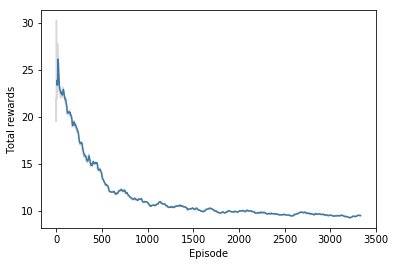

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

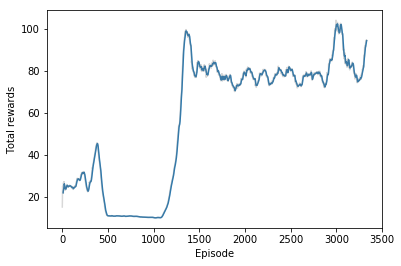

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

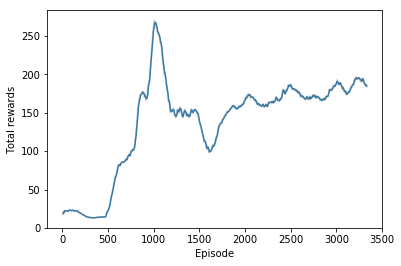

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

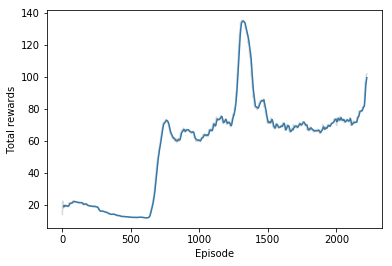

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

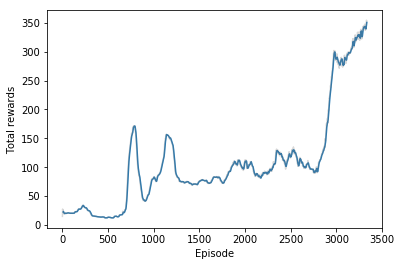

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

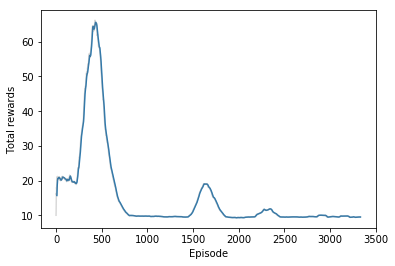

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

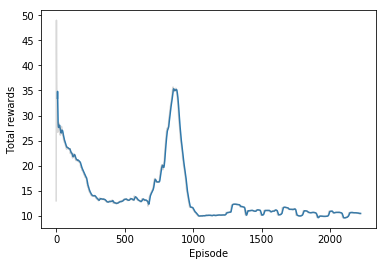

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

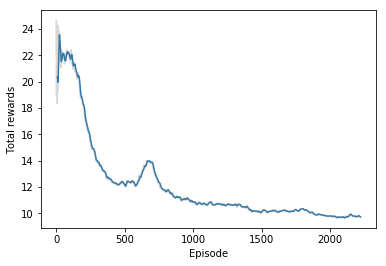

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

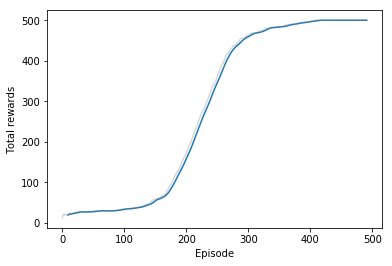

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

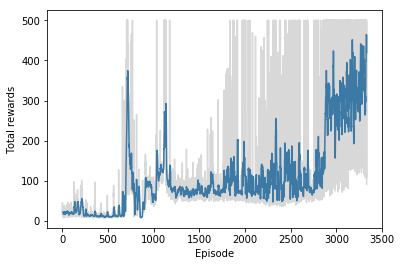

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

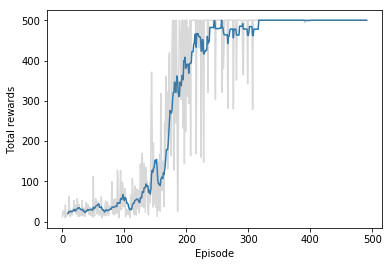

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.